In [25]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import timm 
import cv2
import torchvision
from torchvision.models.feature_extraction import create_feature_extractor


In [26]:
# Cell 1: Define dataset paths
data_dir = r"C:\Users\heman\Desktop\Transfer\Project\DataSets\Raw_Binary_Data"  # Change this to your dataset path
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "validation")
test_dir = os.path.join(data_dir, "test")


In [27]:
# Cell 2: Data Preprocessing and Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True, prefetch_factor=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True, prefetch_factor=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True, prefetch_factor=2)



In [28]:
# Cell 3: Print dataset sizes
print("Dataset sizes:")
for phase, dataset in zip(["Train", "Validation", "Test"], [train_dataset, val_dataset, test_dataset]):
    class_counts = {class_name: 0 for class_name in train_dataset.classes}
    for _, label in dataset:
        class_counts[train_dataset.classes[label]] += 1
    print(f"{phase}: {class_counts}")


Dataset sizes:
Train: {'0_Normal': 2286, '1_Abnormal': 3502}
Validation: {'0_Normal': 328, '1_Abnormal': 498}
Test: {'0_Normal': 639, '1_Abnormal': 1017}


In [29]:
import torch
import torch.nn as nn
import timm

class HRNetKOA(nn.Module):
    def __init__(self, num_classes=2, freeze_backbone=False):
        super(HRNetKOA, self).__init__()
        
        # Load HRNet without classifier
        self.hrnet = timm.create_model('hrnet_w18', pretrained=True, num_classes=0)  # `num_classes=0` removes the classifier

        # Get feature size dynamically
        self.fc_input_size = self._get_hrnet_output_size()
        self.fc = nn.Linear(self.fc_input_size, num_classes)  # Custom classifier

        # Optionally freeze backbone layers
        if freeze_backbone:
            for param in self.hrnet.parameters():
                param.requires_grad = False  # Freeze HRNet layers
        else:
            for param in self.hrnet.parameters():
                param.requires_grad = True   # Make all layers trainable

    def _get_hrnet_output_size(self):
        dummy_input = torch.zeros(1, 3, 224, 224)
        with torch.no_grad():
            output = self.hrnet(dummy_input)
        return output.view(1, -1).size(1)

    def forward(self, x):
        x = self.hrnet(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)  # Pass through custom classifier
        return x

# Initialize model with a trainable backbone
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HRNetKOA(num_classes=2, freeze_backbone=False).to(device)  # Now all layers are trainable

# Example usage: Forward pass
dummy_input = torch.zeros(1, 3, 224, 224).to(device)  # A dummy input tensor
output = model(dummy_input)  # Forward pass through the model

print(f"Output shape: {output.shape}")  # Expected output: (batch_size, num_classes)


Output shape: torch.Size([1, 2])


In [30]:
# Cell 5: Define Focal Loss
def focal_loss(logits, targets, alpha=0.25, gamma=2.0):
    ce_loss = nn.CrossEntropyLoss(reduction='none')(logits, targets)
    p_t = torch.exp(-ce_loss)
    focal_loss = alpha * (1 - p_t) ** gamma * ce_loss
    return focal_loss.mean()


In [31]:

# Cell 6: Define Grad-CAM
def gradcam(image_path, model, target_layer):
    model.eval()
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)
    feature_extractor = create_feature_extractor(model, return_nodes=[target_layer])
    features = feature_extractor(image_tensor)[target_layer]
    weights = features.mean(dim=(2, 3), keepdim=True)
    cam = (weights * features).sum(dim=1, keepdim=True)
    cam = cam.squeeze().detach().cpu().numpy()
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    cam = cv2.resize(cam, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    superimposed_img = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# Example Usage
# gradcam("path_to_image.jpg", model, target_layer="hrnet.layer4")


In [32]:
# Cell 7: Training Setup
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
num_epochs = 20
train_acc, val_acc, train_loss, val_loss = [], [], [], []


In [33]:
import time

optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
num_epochs = 20
train_acc, val_acc, train_loss, val_loss = [], [], [], []

start_time = time.time()  # Track overall training time

for epoch in range(num_epochs):
    epoch_start = time.time()  # Track epoch time

    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = focal_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    train_loss.append(running_loss / len(train_loader))
    train_acc.append(correct / total)

    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = focal_loss(outputs, labels)
            val_running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    val_loss.append(val_running_loss / len(val_loader))
    val_acc.append(val_correct / val_total)

    epoch_time = time.time() - epoch_start  # Time for this epoch
    total_time = time.time() - start_time  # Total elapsed time
    remaining_time = (num_epochs - epoch - 1) * epoch_time  # Estimate remaining time

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.2f}, "
          f"Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_acc[-1]:.2f}, "
          f"Epoch Time: {epoch_time:.2f}s, ETC: {remaining_time/60:.2f} min")

# Total training time
total_training_time = time.time() - start_time
print(f"Total Training Time: {total_training_time / 60:.2f} min")


Epoch 1/20 - Train Loss: 0.0421, Train Acc: 0.63, Val Loss: 0.0462, Val Acc: 0.63, Epoch Time: 1806.99s, ETC: 572.21 min
Epoch 2/20 - Train Loss: 0.0345, Train Acc: 0.72, Val Loss: 0.0333, Val Acc: 0.75, Epoch Time: 1912.30s, ETC: 573.69 min
Epoch 3/20 - Train Loss: 0.0306, Train Acc: 0.75, Val Loss: 0.0615, Val Acc: 0.72, Epoch Time: 1850.26s, ETC: 524.24 min
Epoch 4/20 - Train Loss: 0.0292, Train Acc: 0.78, Val Loss: 0.2206, Val Acc: 0.64, Epoch Time: 1375.77s, ETC: 366.87 min
Epoch 5/20 - Train Loss: 0.0262, Train Acc: 0.81, Val Loss: 0.0370, Val Acc: 0.74, Epoch Time: 1539.27s, ETC: 384.82 min
Epoch 6/20 - Train Loss: 0.0231, Train Acc: 0.84, Val Loss: 0.0402, Val Acc: 0.72, Epoch Time: 1627.90s, ETC: 379.84 min
Epoch 7/20 - Train Loss: 0.0217, Train Acc: 0.85, Val Loss: 0.0384, Val Acc: 0.77, Epoch Time: 1598.98s, ETC: 346.45 min
Epoch 8/20 - Train Loss: 0.0185, Train Acc: 0.88, Val Loss: 0.0430, Val Acc: 0.72, Epoch Time: 1603.72s, ETC: 320.74 min
Epoch 9/20 - Train Loss: 0.0272,

In [34]:

# Cell 10: Evaluate on Test Set
model.eval()
preds, true_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, batch_preds = torch.max(outputs, 1)
        preds.extend(batch_preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())


In [35]:
# Cell 11: Print Metrics
accuracy = accuracy_score(true_labels, preds)
precision = precision_score(true_labels, preds, average='weighted')
recall = recall_score(true_labels, preds, average='weighted')
f1 = f1_score(true_labels, preds, average='weighted')
print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")
print(classification_report(true_labels, preds, target_names=train_dataset.classes))


Accuracy: 0.74, Precision: 0.78, Recall: 0.74, F1 Score: 0.75
              precision    recall  f1-score   support

    0_Normal       0.62      0.84      0.72       639
  1_Abnormal       0.87      0.68      0.77      1017

    accuracy                           0.74      1656
   macro avg       0.75      0.76      0.74      1656
weighted avg       0.78      0.74      0.75      1656



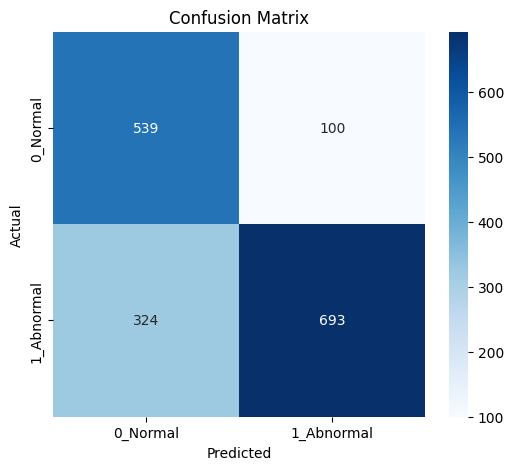

In [36]:
# Cell 12: Confusion Matrix
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

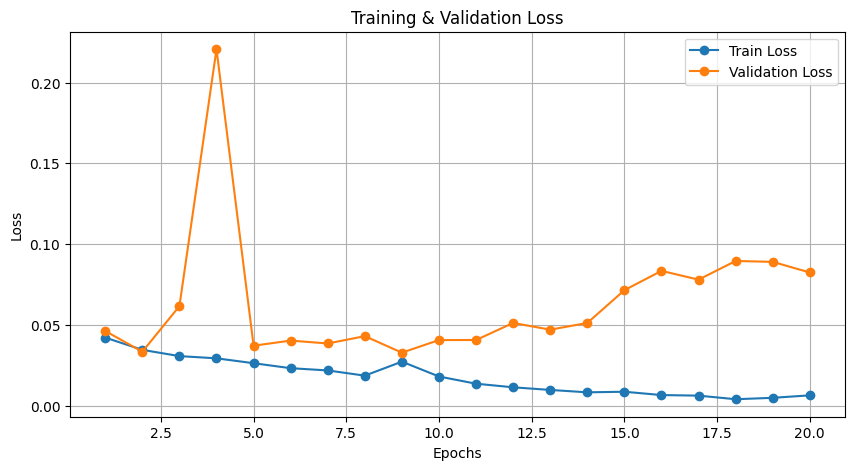

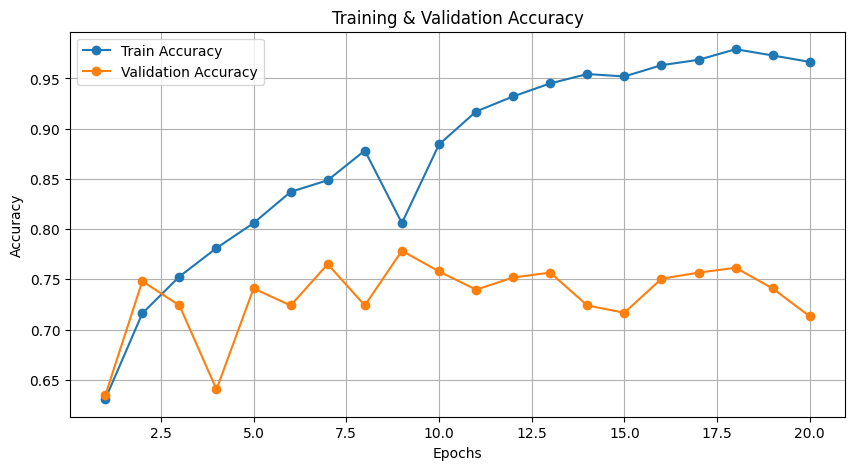

In [39]:
# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss, label="Train Loss", marker="o")
plt.plot(range(1, num_epochs + 1), val_loss, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)

# Plot Training & Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_acc, label="Train Accuracy", marker="o")
plt.plot(range(1, num_epochs + 1), val_acc, label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()
